#### Hi
this will be a CIFAR10 using VGG16 (pre trained model)  
My model (hand made) (the previous one) had 82.2% of accuracy.   
Lets see how this VGG16 will do  

2023/01/30 2027i let get init  


### Update 2023/07/06
I am in my English academy looking at kids taking a test  
What up  
Anyway I am back here for kaggle update  
I want to upload this to kaggle  

In [14]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import time
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision import models

In [15]:
#GPU
import torch

if torch.cuda.is_available():
    device = 'cuda'
    device_count = torch.cuda.device_count()
    if device_count > 1:
        # GPU's
        templist = [1, 2, 3]
        templist = torch.FloatTensor(templist).to(device)
        print("Cuda torch working: ", end="")
        print(templist.is_cuda)
        print("GPU device count: ", end="")
        print(device_count)
        for i in range(device_count):
            print("GPU name {}: {}".format(i, torch.cuda.get_device_name(i)))
        print("current device no.: ", end="")
        print(torch.cuda.current_device())
    else:
        # A GPU
        print("Cuda torch working: ", end="")
        print(torch.cuda.is_available())
        print("GPU device count: ", end="")
        print(device_count)
        print("GPU name: ", end="")
        print(torch.cuda.get_device_name(0))
        print("current device no.: ", end="")
        print(torch.cuda.current_device())
else:
    if torch.backends.mps.is_available():
        print("Apple device detected\nActivating Apple Silicon GPU")
        device = torch.device("mps")
    else:
        print("Cannot use GPU, activating CPU")
        device = 'cpu'


Apple device detected
Activating Apple Silicon GPU


#### Data
since the VGG16 uses 224 x 224 model and CIFAR10 is 32x32 we have to change the CIFAR10 size to 224x224  

In [37]:
# import pandas as pd
# from torchvision.datasets import ImageFolder
# import os
# import torchvision.transforms as transforms
# import torch
# import shutil
# from py7zr import unpack_7zarchive

# num_subprocesses = 4

# train_path = "/kaggle/input/cifar-10/train.7z"
# test_path = "/kaggle/input/cifar-10/test.7z"
# unpacked_train_path = "./train"
# unpacked_test_path = "./test"

# if not os.path.exists(unpacked_train_path):
#     os.makedirs(unpacked_train_path)
#     try:
#         shutil.unpack_archive(train_path, unpacked_train_path)
#     except:
#         train_path = "train.7z"
#         shutil.unpack_archive(train_path, unpacked_train_path)
#     print("Welcome to Kaggle")
# else:
#     print("Using existing unpacked train data")

# if not os.path.exists(unpacked_test_path):
#     os.makedirs(unpacked_test_path)
#     try:
#         shutil.unpack_archive(test_path, unpacked_test_path)
#     except:
#         test_path = "test.7z"
#         shutil.unpack_archive(test_path, unpacked_test_path)
#     print("Welcome Home")
# else:
#     print("Using existing unpacked test data")

# transform = transforms.Compose(
#     [transforms.Resize((224, 224)),
#      transforms.ToTensor(),
#      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# try:
#     train_labels = pd.read_csv("/kaggle/input/cifar-10/trainLabels.csv")
# except:
#     train_labels = pd.read_csv("trainLabels.csv")

# trainset = ImageFolder(root=unpacked_train_path, transform=transform)
# trainloader = torch.utils.data.DataLoader(trainset, batch_size=32,
#                                           shuffle=True, num_workers=num_subprocesses)

# testset = ImageFolder(root=unpacked_test_path, transform=transform)
# testloader = torch.utils.data.DataLoader(testset, batch_size=32,
#                                          shuffle=False, num_workers=num_subprocesses)


Using existing unpacked train data
Using existing unpacked test data


In [40]:
import os
import pandas as pd
import torch
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from torchvision.io import read_image

class CustomImageDataset(Dataset):
    def __init__(self, labels_df, img_dir, transform=None, target_transform=None):
        self.img_labels = labels_df
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, str(self.img_labels.iloc[idx, 0])+'.png')
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# 레이블 데이터 로드
try:
    train_labels = pd.read_csv("/kaggle/input/cifar-10/trainLabels.csv")
except:
    train_labels = pd.read_csv("trainLabels.csv")

dataset = CustomImageDataset(train_labels, './train', transform=transform)

# 데이터셋을 훈련 세트와 검증 세트로 분할
train_idx, val_idx = train_test_split(list(range(len(dataset))), test_size=0.2, random_state=42)
train_dataset = torch.utils.data.Subset(dataset, train_idx)
val_dataset = torch.utils.data.Subset(dataset, val_idx)

# 데이터 로더 생성
trainloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valloader = DataLoader(val_dataset, batch_size=32, shuffle=False)


RuntimeError: [Errno 2] No such file or directory: './train/12737.png'

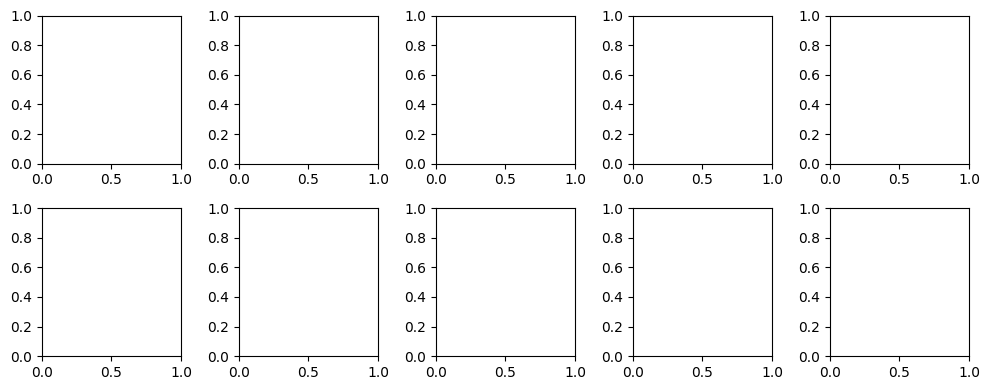

In [42]:
import random
import matplotlib.pyplot as plt

# Get the indices of random samples
random_indices = random.sample(range(len(trainloader.dataset)), 10)

# Plot the images with labels
fig, axs = plt.subplots(2, 5, figsize=(10, 4))
fig.tight_layout()

for i, idx in enumerate(random_indices):
    image, label = trainloader.dataset[idx]
    image = image.permute(1, 2, 0)  # Reshape from (C, H, W) to (H, W, C)

    ax = axs[i // 5][i % 5]
    ax.imshow(image)
    ax.set_title(trainloader.dataset.img_labels.iloc[label][1])
    ax.axis('off')

plt.show()

#### VGG
I will use the predtrained vgg  
The default out features of vgg16 is 1000. But we need only one.  
So we will need line no 5. to change the out features to 10  
And since we will not change the parameters we will not require grad  
  


In [17]:
vgg16 = models.vgg16(pretrained=True)
vgg16.to(device)

# change the number of classes 
vgg16.classifier[6].out_features = 10

# freeze convolution weights
# BUT convolutional layers WILL learn // allowing the model to focus on learning the mapping between the extracted features and the output predictions
for param in vgg16.features.parameters():
    param.requires_grad = False

print(vgg16)

/Users/owo/anaconda3/envs/torchenv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/owo/anaconda3/envs/torchenv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

#### LOSS and Optim


In [18]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg16.classifier.parameters(), lr=0.001, momentum=0.9)

In [19]:
#validation function
def validate(model, test_dataloader):
    model.eval()
    val_running_loss = 0.0
    val_running_correct = 0
    for int, data in enumerate(test_dataloader):
        data, target = data[0].to(device), data[1].to(device)
        output = model(data)
        loss = criterion(output, target)
        
        val_running_loss += loss.item()
        _, preds = torch.max(output.data, 1)
        val_running_correct += (preds == target).sum().item()
    
    val_loss = val_running_loss/len(test_dataloader.dataset)
    val_accuracy = 100. * val_running_correct/len(test_dataloader.dataset)
    
    return val_loss, val_accuracy

In [20]:
# training function
def train(model, train_dataloader):
    model.train()
    train_running_loss = 0.0
    train_running_correct = 0
    for i, data in enumerate(train_dataloader):
        data, target = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        train_running_loss += loss.item()
        _, preds = torch.max(output.data, 1)
        train_running_correct += (preds == target).sum().item()
        loss.backward()
        optimizer.step()
    train_loss = train_running_loss/len(train_dataloader.dataset)
    train_accuracy = 100. * train_running_correct/len(train_dataloader.dataset)

    #print('Train Loss: %.4f'%train_loss)
    
    return train_loss, train_accuracy

In [21]:
NB_EPOCH = 0

train_loss , train_accuracy = [], []
val_loss , val_accuracy = [], []
start = time.time()
for epoch in range(NB_EPOCH):
    train_epoch_loss, train_epoch_accuracy = train(vgg16, trainloader)
    val_epoch_loss, val_epoch_accuracy = validate(vgg16, testloader)
    print("Train Loss : %f/  Train Acc : %.2f/  Val Loss : %f/  Val Acc : %.2f"%(train_epoch_loss,train_epoch_accuracy,val_epoch_loss,val_epoch_accuracy))
    train_loss.append(train_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)
    val_loss.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)

    #print("Train Acc : %f"%train_accuracy,"Val Acc : %f"%val_accuracy)

torch.save(vgg16.state_dict(), "vgg16cifar10.pth")

end = time.time()
print(int((end - start) // 60), 'minutes', int((end - start) % 60), 'seconds')

0 minutes 0 seconds


In [35]:
import pandas as pd
from torchvision import models, transforms
from PIL import Image
import os
from tqdm import tqdm
import sklearn
# Instantiate the model and set to evaluation mode
vgg16 = models.vgg16(pretrained=True)
vgg16.eval()
vgg16.to(device)

# Create transform function
transform = transforms.Compose(
    [transforms.Resize((224, 224)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Label Encoder
le = sklearn.preprocessing.LabelEncoder()
le.fit(train_labels["label"])

# Prepare the test data folder
test_data_folder = "./test/test"

# Create a DataFrame to hold the results
results_df = pd.DataFrame(columns=['id', 'label'])

# Iterate over the test images
for i in tqdm(range(1, 300001)):
    print("number %d"%i)
    # Load the image
    image_path = os.path.join(test_data_folder, f"{i}.png")
    image = Image.open(image_path)
    
    # Transform the image and add a batch dimension
    image = transform(image).unsqueeze(0).to(device)
    
    # Make a prediction
    with torch.no_grad():
        outputs = vgg16(image)
        _, predicted = torch.max(outputs.data, 1)
    
    # Inverse transform the predicted label
    predicted_label = le.inverse_transform(predicted.cpu().numpy())[0]
    
    # Add the result to the DataFrame
    results_df = results_df.append({'id': i, 'label': predicted_label}, ignore_index=True)

# Save the results to a CSV file
results_df.to_csv("sampleSubmission.csv", index=False)


/Users/owo/anaconda3/envs/torchenv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/owo/anaconda3/envs/torchenv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
  0%|          | 0/300000 [00:00<?, ?it/s]

number 1


  0%|          | 0/300000 [00:00<?, ?it/s]


ValueError: y contains previously unseen labels: [675]

In [30]:
num_batches = len(testloader)
print("Number of batches:", num_batches)

Number of batches: 9375


In [27]:
# Iterate over the testloader to access the first batch
for inputs, _, _ in testloader:
    # Process or use the inputs in the first batch
    print(inputs)


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x15756f380>
Traceback (most recent call last):
  File "/Users/owo/anaconda3/envs/torchenv/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/Users/owo/anaconda3/envs/torchenv/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1442, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/Users/owo/anaconda3/envs/torchenv/lib/python3.11/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/owo/anaconda3/envs/torchenv/lib/python3.11/multiprocessing/popen_fork.py", line 40, in wait
    if not wait([self.sentinel], timeout):
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/owo/anaconda3/envs/torchenv/lib/python3.11/multiprocessing/connection.py", line 930, in wait
    ready = selector.select(timeout)
            ^^^^^^^

ValueError: not enough values to unpack (expected 3, got 2)

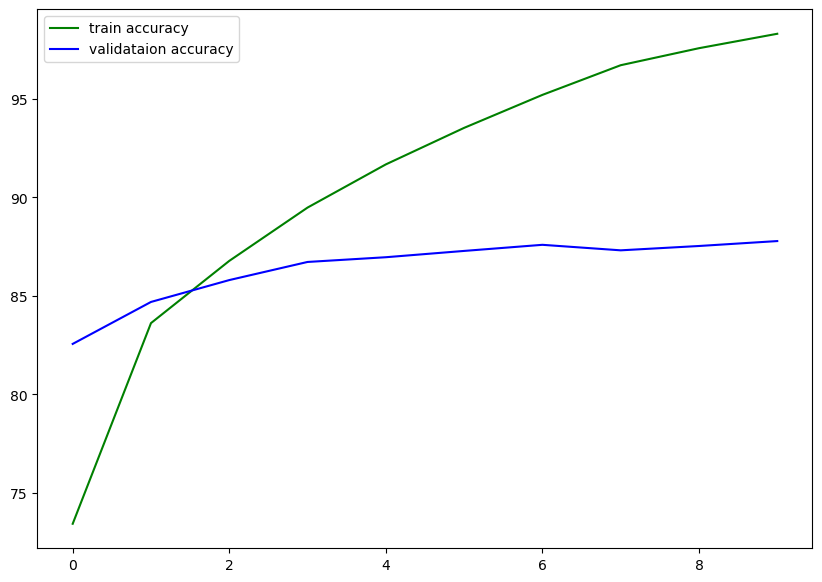

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(train_accuracy, color='green', label='train accuracy')
plt.plot(val_accuracy, color='blue', label='validataion accuracy')
plt.legend()
plt.savefig('accuracy.png')
plt.show()

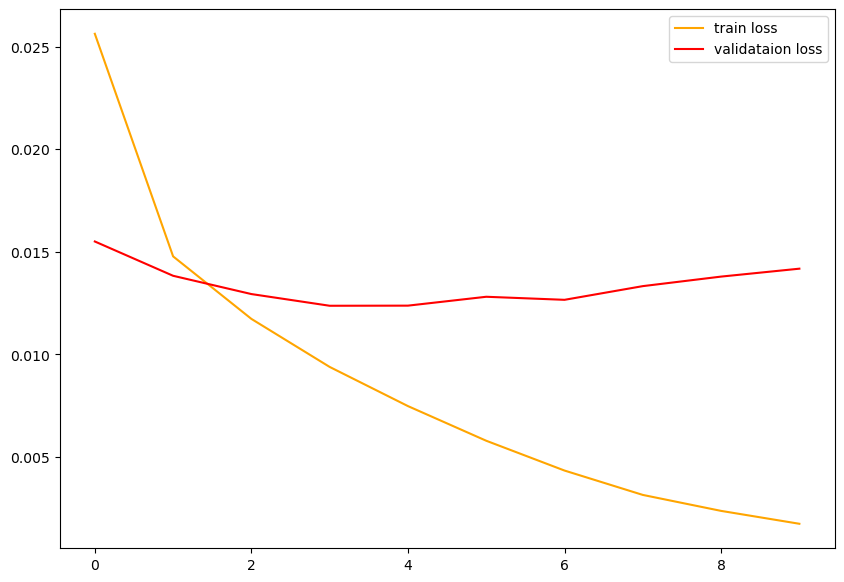

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(train_loss, color='orange', label='train loss')
plt.plot(val_loss, color='red', label='validataion loss')
plt.legend()
plt.savefig('loss.png')
plt.show()